# Rascunho

In [3]:
import numpy as np
import pystan as ps
import sympy as sp
import networkx as nx

import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
sns.set()

from scipy.special import expit, logit

%matplotlib inline

import pickle

import sys
sys.path.append('../scripts/')

from utilits import ParameterAlpha, BivariateBeta

In [160]:
compiled = True
#compiled = False

if compiled: 
    sm1 = pickle.load(open('../models/extra/sketch-v1.pkl', 'rb'))
else: 
    sm1 = ps.StanModel(file = '../models/extra/sketch-v1.stan')
    with open('../models/extra/sketch-v1.pkl', 'wb') as f:
        pickle.dump(sm1, f)
        
compiled = True
#compiled = False

if compiled: 
    sm2 = pickle.load(open('../models/extra/sketch-v2.pkl', 'rb'))
else: 
    sm2 = ps.StanModel(file = '../models/extra/sketch-v2.stan')
    with open('../models/extra/sketch-v2.pkl', 'wb') as f:
        pickle.dump(sm2, f)
        
compiled = True
#compiled = False

if compiled: 
    sm3 = pickle.load(open('../models/extra/sketch-v3.pkl', 'rb'))
else: 
    sm3 = ps.StanModel(file = '../models/extra/sketch-v3.stan')
    with open('../models/extra/sketch-v3.pkl', 'wb') as f:
        pickle.dump(sm3, f)
        
compiled = True
#compiled = False

if compiled: 
    sm4 = pickle.load(open('../models/extra/sketch-v4.pkl', 'rb'))
else: 
    sm4 = ps.StanModel(file = '../models/extra/sketch-v4.stan')
    with open('../models/extra/sketch-v4.pkl', 'wb') as f:
        pickle.dump(sm4, f)

#compiled = True
compiled = False

if compiled: 
    sm5 = pickle.load(open('../models/extra/sketch-v5.pkl', 'rb'))
else: 
    sm5 = ps.StanModel(file = '../models/extra/sketch-v5.stan')
    with open('../models/extra/sketch-v5.pkl', 'wb') as f:
        pickle.dump(sm5, f)
        
#compiled = True
compiled = False

if compiled: 
    sm6 = pickle.load(open('../models/extra/sketch-v6.pkl', 'rb'))
else: 
    sm6 = ps.StanModel(file = '../models/extra/sketch-v6.stan')
    with open('../models/extra/sketch-v6.pkl', 'wb') as f:
        pickle.dump(sm6, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6bd01db4bd2e68e357e45305da6da55d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_37b530408b35107c61e4e77ff87169c6 NOW.


In [237]:
n = 300
p = 10

X = np.random.multivariate_normal(mean = np.zeros(p+1),
                                  cov = np.eye(p+1), 
                                  size = n)
X = (X - X.mean(axis = 0))/X.std(axis = 0)
X[:,0] = 1

#W = nx.adjacency_matrix(nx.generators.trees.random_tree(n = n)).toarray()
W = nx.adjacency_matrix(nx.random_graphs.erdos_renyi_graph(n = n, p = 0.1)).toarray()
for i in range(n):
    if sum(W[i,:]) == 0:
        j = np.random.choice([k for k in range(n) if k != i])
        W[i,j] = 1
        W[j,i] = 1
        
W_n = W.sum() // 2
D = np.diag(W.sum(axis = 1))

rho = 0.5
tau = 1
prev  = 0.2
beta = np.array([logit(prev), -1.5, 0.4, 1, 0, 0.3, -0.8, 2, 0.9, 1.3, -1.93])

phi = np.random.multivariate_normal(mean = np.zeros(n), 
                                    cov = (1/tau) * np.linalg.inv(D - rho * W))

y = np.random.binomial(n = 1, p = expit(phi + X @ beta))
#y = np.random.poisson(np.exp(logit(prev) + phi + log_offset))

mu_beta = np.zeros(p+1)
mu_beta[0] = -2.7

cov_beta = np.eye(p+1)
cov_beta[0,0] = 1.3
    
data5 = {
    "n": n,
    "p": p,
    "X": X[:,1:],
    "y": y,
    "W": W,
    "W_n": W_n,
    "mu_beta": mu_beta[1:],
    "cov_beta": cov_beta[1:,1:],
    "alpha_tau": 0.01,
    "beta_tau": 0.01,
    "alpha_prev": 1,
    "beta_prev": 9,
    "lambda_tau": np.log(10),
    "gumbel_prior": 1,
}

data6 = {
    "n": n,
    "p": p,
    "X": X,
    "y": y,
    "W": W,
    "W_n": W_n,
    "mu_beta": mu_beta,
    "cov_beta": cov_beta,
    "alpha_tau": 0.01,
    "beta_tau": 0.01,
    "lambda_tau": np.log(10),
    "gumbel_prior": 1,
}

In [238]:
%%time
fit5 = sm5.sampling(data=data5, 
                   control = {'adapt_delta': 0.9}, 
                   iter = 4000
                  )
summary5 = az.summary(fit5)

CPU times: user 4.74 s, sys: 113 ms, total: 4.85 s
Wall time: 1min 23s


In [239]:
%%time
fit6 = sm6.sampling(data=data6, 
                   control = {'adapt_delta': 0.9}, 
                   iter = 4000
                  )
summary6 = az.summary(fit6)

CPU times: user 4.5 s, sys: 149 ms, total: 4.64 s
Wall time: 1min 27s


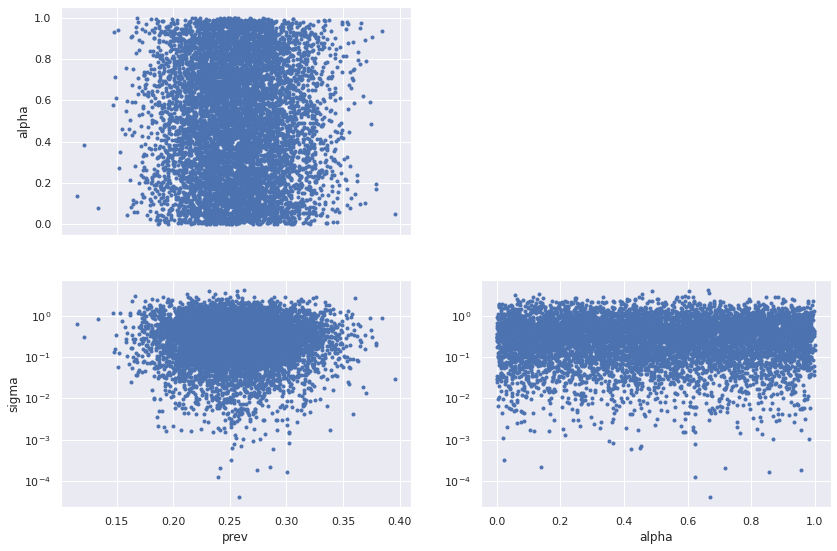

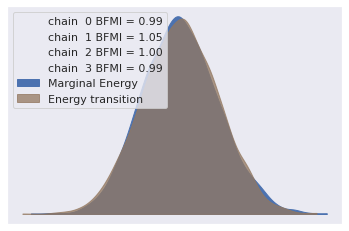

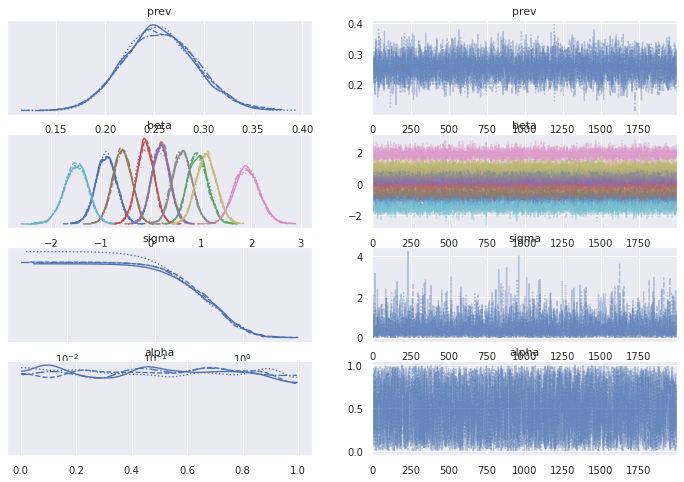

In [240]:
inference_data = az.convert_to_inference_data(fit5)
ax = az.plot_pair(inference_data, var_names=('prev', 'alpha', 'sigma'), 
                  divergences=True, group = 'posterior')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
plt.show()

az.plot_energy(fit5)
plt.show()

ax = az.plot_trace(fit5, var_names=('prev', 'beta', 'sigma', 'alpha'))
ax[2,0].set_xscale('log')
plt.show()

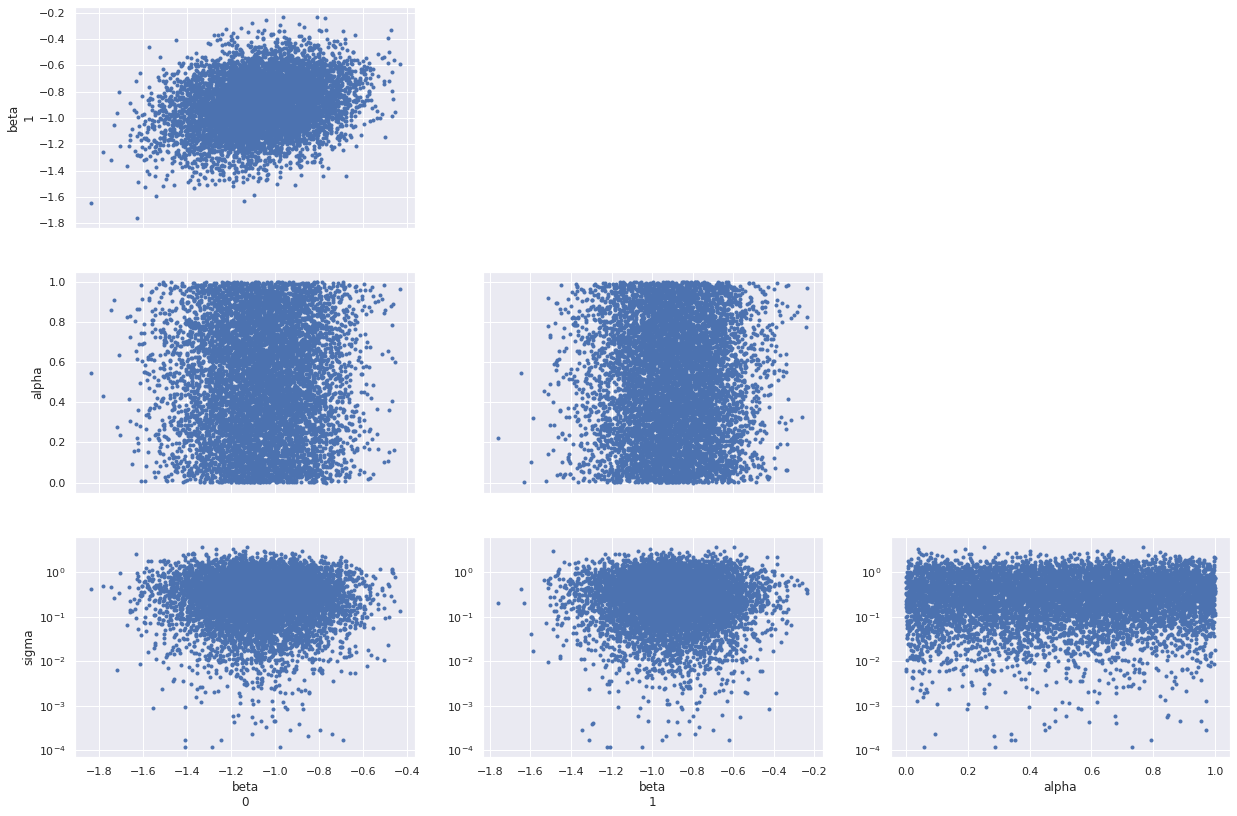

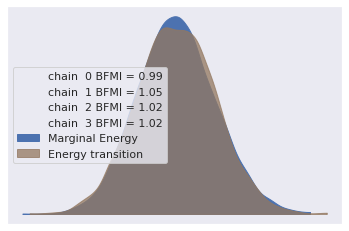

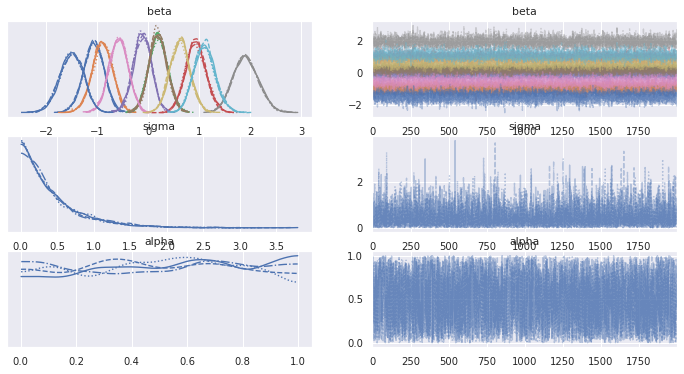

In [245]:
inference_data = az.convert_to_inference_data(fit6)
ax = az.plot_pair(inference_data, var_names=('beta', 'alpha', 'sigma'),
                  coords={'beta_dim_0': [0,1]},
                  divergences=True, group = 'posterior')
ax[2,0].set_yscale('log')
ax[2,1].set_yscale('log')
ax[2,2].set_yscale('log')
plt.show()

az.plot_energy(fit6)
plt.show()

ax = az.plot_trace(fit6, var_names=('beta', 'sigma', 'alpha'))
plt.show()